In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)):
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:


def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i])
        dataY.append(d_y[i + fore_cast,:])

    return np.array(dataX), np.array(dataY)

In [5]:
#from google.colab import drive

#drive.mount('/content/drive')
#path =path = '/content/drive/MyDrive/nmchr_lab/Subjects/inclined/new/right_based/'


In [44]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\SD\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [45]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']
#file_name = ['TH_4_I.xls', 'TH_2_I.xls', 'TH_3_I.xls']

# Subj TH:
#file_name = ['TH_4_I_r.xlsx', 'TH_2_I_r.xlsx', 'TH_3_I_r.xlsx']

# Subj JJ:
#file_name = ['JJ_4_I.xlsx', 'JJ_6_I.xlsx', 'JJ_7_I.xlsx']
#file_name = ['JJ_4_I_r.xlsx', 'JJ_6_I_r.xlsx', 'JJ_7_I_r.xlsx']

# Subj SD:
file_name = ['SD_1_I_r.xls', 'SD_4_I_r.xls', 'SD_2_I_r.xls', 'SD_3_I_r.xls', 'SD_5_I_r.xls']

# Subj PK:
#file_name = ['PK_0_I_r.xls', 'PK_5_I_r.xls', 'PK_2_I_r.xls', 'PK_3_I_r.xls']

# Subj SKS:
#file_name = ['SKS_0_I_r.xls', 'SKS_4_I_r.xls', 'SKS_2_I_r.xls', 'SKS_3_I_r.xls', 'SKS_5_I_r.xls']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [46]:
file_name

['SD_1_I_r.xls',
 'SD_4_I_r.xls',
 'SD_2_I_r.xls',
 'SD_3_I_r.xls',
 'SD_5_I_r.xls']

In [47]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217324 entries, 0 to 217323
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      217324 non-null  float64
 1   l_ph_ank      217324 non-null  float64
 2   l_ph_fo       217324 non-null  float64
 3   r_ph_hip      217324 non-null  float64
 4   r_ph_ank      217324 non-null  float64
 5   r_ph_fo       217324 non-null  float64
 6   n_lgrf        217324 non-null  float64
 7   n_r_grf       217324 non-null  float64
 8   n_lcop        217324 non-null  float64
 9   n_rcop        217324 non-null  float64
 10  perc_new      217324 non-null  float64
 11  st_sw_phase   217324 non-null  int64  
 12  strike_frame  217324 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 21.6 MB


In [48]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table


,l_ph_hip,l_ph_ank,l_ph_fo,r_ph_hip,r_ph_ank,r_ph_fo,n_lgrf,n_r_grf,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.673739,0.736829,0.914034,0.970959,0.890194,0.725464,0.851698,0.038716,0.000574,0.000087,0.000000,1,1
1,0.661113,0.736861,0.857709,0.970149,0.867097,0.723976,0.850599,0.056193,0.000775,0.000341,0.485437,1,2
2,0.643729,0.736777,0.826134,0.969180,0.850208,0.722145,0.846957,0.076920,0.001005,0.000648,0.970874,1,3
3,0.618890,0.736593,0.807199,0.967984,0.837624,0.719934,0.840608,0.100584,0.001265,0.001014,1.456311,1,4
4,0.582659,0.736319,0.794798,0.966495,0.828041,0.717283,0.831510,0.126708,0.001553,0.001443,1.941748,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
216121,0.709008,0.729804,0.153638,0.970786,0.103645,0.747567,0.841359,0.000000,0.114418,-0.000162,97.247706,0,213
216122,0.705001,0.731119,0.122165,0.970118,0.067068,0.746327,0.846958,0.000000,0.115602,0.000023,97.706422,0,214
216123,0.700264,0.732089,0.069623,0.969647,0.023338,0.745068,0.852063,0.000000,0.116671,0.000254,98.165138,0,215
216124,0.694542,0.732789,0.992246,0.969320,0.977844,0.743771,0.856313,0.000000,0.117630,0.000534,98.623853,0,216


In [49]:
## ------ Left Leg -------

## Hip, COP
drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "n_rcop", "r_ph_hip", "r_ph_fo", "l_ph_fo"]
## Hip, Foot, COP
#drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "n_rcop", "r_ph_hip", "r_ph_fo"]

## ------ Right Leg ------

## Hip, COP
#drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "n_lcop", "l_ph_hip", "l_ph_fo", "r_ph_fo"]
## Hip, Foot, COP
#drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "n_lcop", "l_ph_hip", "l_ph_fo"]

## ------ Both Leg ------

## Hip, COP
#drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase", "l_ph_fo", "r_ph_fo"]
## Hip, Foot, COP
#drop_list = ["n_lgrf","n_r_grf","l_ph_ank","r_ph_ank", "st_sw_phase"]

In [50]:
source_table = source_table.drop(drop_list, axis = 1)#,'l_ph_hip','l_ph_fo','n_lcop'], axis = 1)
source_table

,l_ph_hip,n_lcop,perc_new,strike_frame
0,0.673739,0.000574,0.000000,1
1,0.661113,0.000775,0.485437,2
2,0.643729,0.001005,0.970874,3
3,0.618890,0.001265,1.456311,4
4,0.582659,0.001553,1.941748,5
...,...,...,...,...
216121,0.709008,0.114418,97.247706,213
216122,0.705001,0.115602,97.706422,214
216123,0.700264,0.116671,98.165138,215
216124,0.694542,0.117630,98.623853,216


In [51]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [52]:
data_y = y.values.reshape(-1,2)

In [53]:
type(data_y)

numpy.ndarray

In [54]:


#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25,
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [55]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(162083, 10, 3)
(162083, 2)
(54021, 10, 3)
(54021, 2)


In [56]:
train_x.shape

(162083, 10, 3)

In [57]:


n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(5401, 10, 3)
(5401, 2)


In [58]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        print(x.shape)
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [60]:
import tensorflow as tf
lr = 0.001
epochs = 30
batch = 128
n_features=train_x.shape[2]
seq_len = train_x.shape[1]
x=Input(shape=(seq_len, train_x.shape[2]))


l1=tf.keras.layers.AveragePooling1D(
    pool_size=2,
    strides=None)(x)
att1 = attention()(x)
rep_layer = L.RepeatVector((seq_len))(att1)

l2=L.Dense(n_features)(x)
print(l1.shape)
print(l2.shape)

inp=tf.concat([l1,rep_layer,l2],1)
print(inp.shape)
# RNN_layer = SimpleRNN(hidden_units, return_sequences=True, activation=activation)(x)
LSTM_layer2 = LSTM(32, return_sequences=True)(inp)
# attn_layer1 = attention()(LSTM_layer2)
tmp_layer = L.Flatten()(LSTM_layer2)
lin_layer1= L.Dense(32)(tmp_layer)
lin_layer2 = L.Dense(2)(lin_layer1)
# rep_layer = L.RepeatVector((10))(attn_layer1)
# attn_layer2 = attention()(rep_layer)
# LSTM_layer3 = LSTM(32, return_sequences=True)(rep_layer)
# LSTM_layer4 = LSTM(64, return_sequences=True)(LSTM_layer3)
# lin_layer = L.TimeDistributed(L.Dense(n_features))(LSTM_layer4)
# tmp_layer = Flatten()(rep_layer)
# lin_layer = L.Dense(2)(tmp_layer)
model=Model(x,lin_layer2)
model.summary()
adam = optimizers.Adam(lr)
model.compile(loss='mse', optimizer=adam)

(None, 10, 3)
(None, 5, 3)
(None, 10, 3)
(None, 25, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 attention_3 (attention)        (None, 3)            13          ['input_4[0][0]']                
                                                                                                  
 average_pooling1d_3 (AveragePo  (None, 5, 3)        0           ['input_4[0][0]']                
 oling1D)                                                                                         
                                                                                                  
 repeat_vector_3 (RepeatVector)  (Non

In [61]:
model_history = model.fit( train_x, train_y, epochs=epochs, batch_size=batch,  verbose=1)

Epoch 1/30
(None, 10, 3)
(None, 10, 3)
1267/1267 [==============================] - 12s 8ms/step - loss: 0.0327
Epoch 2/30
1267/1267 [==============================] - 11s 8ms/step - loss: 0.0110
Epoch 3/30
1267/1267 [==============================] - 11s 8ms/step - loss: 0.0088
Epoch 4/30
1267/1267 [==============================] - 11s 8ms/step - loss: 0.0076
Epoch 5/30
1267/1267 [==============================] - 11s 8ms/step - loss: 0.0071
Epoch 6/30
1267/1267 [==============================] - 11s 8ms/step - loss: 0.0068
Epoch 7/30
1267/1267 [==============================] - 11s 8ms/step - loss: 0.0066
Epoch 8/30
1267/1267 [==============================] - 11s 8ms/step - loss: 0.0064
Epoch 9/30
1267/1267 [==============================] - 11s 8ms/step - loss: 0.0062
Epoch 10/30
1267/1267 [==============================] - 11s 8ms/step - loss: 0.0060
Epoch 11/30
1267/1267 [==============================] - 14s 11ms/step - loss: 0.0060
Epoch 12/30
1267/1267 [======================

In [62]:
#model.save(path+"cnn_new_model_all_sub_2_leg_")

In [63]:
#model = tf.keras.models.load_model(path+"cnn_new_model_sd_sks_th")

In [64]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [65]:
# trainPredict = model.predict(train_x)
testPredict = model.predict(validation_x)

(None, 10, 3)
1689/1689 [==============================] - 4s 2ms/step


In [66]:

testPredict.shape

(54021, 2)

In [67]:
from sklearn.metrics import mean_squared_error

# trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
# print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.07 RMSE


In [68]:
v = X_test[11:]
v.shape

(54021, 3)

In [69]:
x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  
  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) : 
    pred[iter] = pred[iter] - 100  
    if abs(pred[iter]) >= 5:
      pred[iter] = 0 
  

  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
    pred[iter] = 100 - pred[iter]
    if abs(pred[iter]) >= 5:
        pred[iter] = 100


In [70]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [71]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)): # or (actual[iter]>98) or(actual[iter]<3):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

30301
54021
Precision  1 :  56.09114973806483
44570
54021
Precision  2 :  82.50495177801226
50063
54021
Precision  3 :  92.67321967383054
52331
54021
Precision  4 :  96.87158697543548
53304
54021
Precision  5 :  98.67273837951907


In [72]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)



Predicting Percentage RMSE:  1.6346160344464542


In [73]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

54021
54021
1.6346160344464542


32041
54021


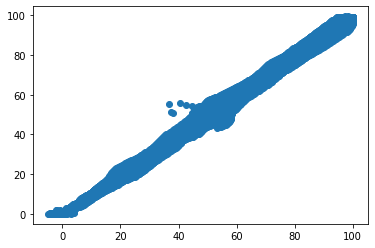

In [74]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<5 or actual[iter]>95:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

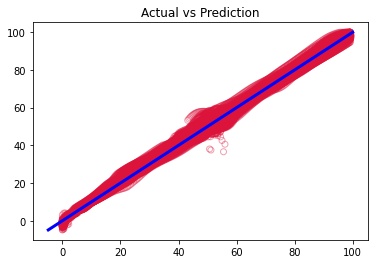

In [75]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

In [76]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\JJ\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [77]:
file_name = ['JJ_4_I_r.xlsx', 'JJ_6_I_r.xlsx', 'JJ_7_I_r.xlsx']


for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path+ file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)

cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table
source_table = source_table.drop(drop_list, axis = 1)#,'l_ph_hip','l_ph_fo','n_lcop'], axis = 1)

x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled
data_y = y.values.reshape(-1,2)
look_back=10
fore_cast=1
val_new_x, val_new_y = convert_data(data_x, data_y, look_back, fore_cast)


In [78]:
testPredict = model.predict(val_new_x)

12143/12143 [==============================] - 29s 2ms/step


In [79]:
v = val_new_x[11:]
v.shape

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  # pred1=pd.DataFrame(pred).sort_index().reset_index()

actual = np.zeros((len(val_new_y),1))

for iter in range(len(val_new_x)):
  x =val_new_y[iter][0]
  y =val_new_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))



correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)) or (actual[iter]>98) or(actual[iter]<3):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

99532
388567
Precision  1 :  25.615144878489424
147733
388567
Precision  2 :  38.0199553744914
176589
388567
Precision  3 :  45.446216482614325
199779
388567
Precision  4 :  51.41429920708655
220704
388567
Precision  5 :  56.79947087632249


In [80]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

Predicting Percentage RMSE:  19.011823785240434
381659
388567
14.478702472954078


Text(0.5, 1.0, 'Actual vs Prediction')

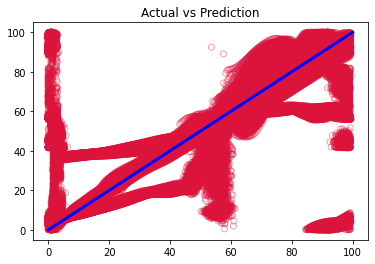

In [81]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')